In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf

/Users/maximeszymanski/PycharmProjects/StocksClusteringVAE/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[*********************100%%**********************]  1 of 1 completed
shape before : (1006,)
shape after : (1000,)


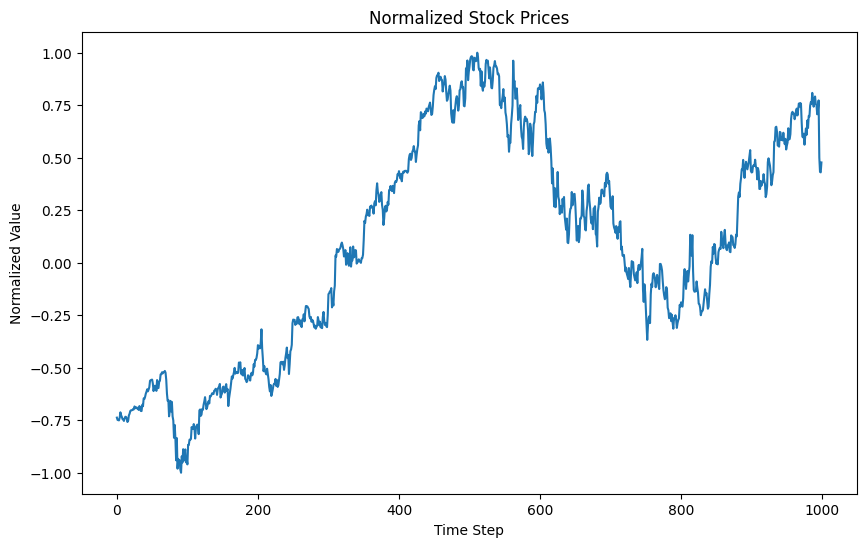

In [2]:

# Define the stock symbol (Google in this case)
stock_symbol = 'GOOGL'

# Define the date range for the past 4 years
start_date = '2019-11-08'
end_date = '2023-11-08'

# Download historical stock data using yfinance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Extract the 'Close' column
close_values = stock_data['Close'].values

# Normalize the data between -1 and 1
normalized_values = 2 * (close_values - np.min(close_values)) / np.ptp(close_values) - 1
print(f"shape before : {normalized_values.shape}")
# remove the last 6 values
normalized_values = normalized_values[:-6]
print(f"shape after : {normalized_values.shape}")
# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(normalized_values)
plt.title('Normalized Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.show()

In [3]:
sub_series_length = 20
assert len(normalized_values) % sub_series_length == 0
sub_series = normalized_values.reshape((-1, sub_series_length))
print(f"sub_series shape : {sub_series.shape}")


sub_series shape : (50, 20)


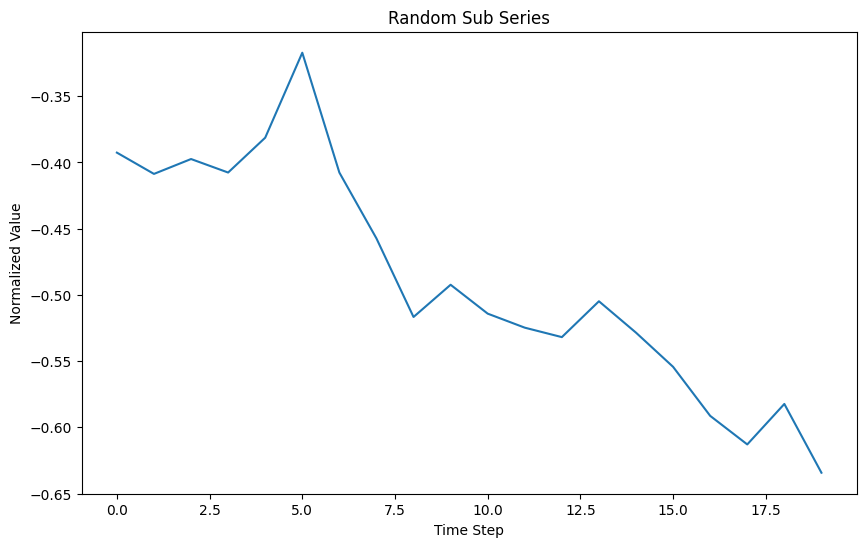

In [4]:
# print a random sub series
random_index = np.random.randint(0, sub_series.shape[0])
plt.figure(figsize=(10, 6))
plt.plot(sub_series[random_index])
plt.title('Random Sub Series')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.show()


In [85]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64,num_layers=3,bidirectional=False,
               transfromer_hidden_size_attention = 64,num_heads=8,sub_seq_len=20):
    super(Encoder, self).__init__()
    assert seq_len % sub_seq_len  == 0
    self.number_of_sub_seq = seq_len // sub_seq_len
    self.sub_seq_len = sub_seq_len
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    print(f"hidden_dim: {self.hidden_dim}")
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.rnn1 = nn.LSTM(
          input_size=embedding_dim,
          hidden_size=self.hidden_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )


    multiple_bi = 2 if bidirectional else 1

    self.rnn2 = nn.LSTM(
          input_size=multiple_bi * self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=self.num_layers,
          batch_first=True
    )
    #self.positional_encoding = PositionalEncoding(embedding_dim)
    self.embedding_layer = nn.Linear(n_features, embedding_dim)
    print(f"embedding_dim: {embedding_dim}")
    self.transformer_1 = CompressWithAttentionResidual(input_size=embedding_dim,output_size=embedding_dim,
                                             hidden_size_attention=embedding_dim,
                                             group_size=self.number_of_sub_seq)


  def forward(self, x):
    batch_size, seq_len, n_features = x.size()
    #x = x.reshape((batch_size * seq_len, n_features))
    x = self.embedding_layer(x)
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    x = self.transformer_1(x)
    x = x.reshape((batch_size, self.sub_seq_len, self.embedding_dim))

    return x



class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1,num_layers=3,bidirectional=False,
               sub_seq_len=20):
    super(Decoder, self).__init__()
    assert seq_len % sub_seq_len  == 0
    self.number_of_sub_seq = seq_len // sub_seq_len
    self.sub_seq_len = sub_seq_len
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.output_embeding = OutputEmbedding(input_dim=self.hidden_dim,seq_len=self.seq_len,output_dim=1)
    self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )

    multiple_bi = 2 if bidirectional else 1
    self.rnn2 = nn.LSTM(
      input_size=input_dim * multiple_bi,
      hidden_size=self.hidden_dim,
      num_layers=self.num_layers,
      batch_first=True
    )
  def forward(self, x):


    batch_size = x.size(0)
    # x is shape (batch_size, 1, n_features)
    # repeat the last dimension to have (batch_size, seq_len, n_features)
    x = x.repeat(1, self.seq_len // self.sub_seq_len, 1)
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((batch_size,self.seq_len, self.hidden_dim))
    x = self.output_embeding(x)

    # keep only the last layer


    return x

class CompressWithAttentionResidual(nn.Module):
    def __init__(self, input_size, output_size, hidden_size_attention, group_size):
        super(CompressWithAttentionResidual, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size_attention
        self.group_size = group_size

        # Linear projections for attention
        self.Q_linear = nn.Linear(self.input_size, self.hidden_size)
        self.K_linear = nn.Linear(self.input_size, self.hidden_size)
        self.V_linear = nn.Linear(self.input_size, self.hidden_size)

        # Final linear transformations
        self.attention_output_linear = nn.Linear(self.hidden_size, self.hidden_size)
        self.output_linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        # x is shape (batch_size, seq_len, n_features)
        batch_size, seq_len, n_features = x.size()
        # Reshape input into groups of size self.group_size
        x = x.view(batch_size, -1, self.group_size, n_features)
        group_len = x.size(1)

        # Linear projections for attention
        Q = self.Q_linear(x)
        K = self.K_linear(x)
        V = self.V_linear(x)

        # Compute attention weights
        attention_weights = torch.matmul(Q, K.transpose(-2, -1)) / (self.hidden_size ** 0.5)
        attention_weights = F.softmax(attention_weights, dim=-1)

        # Apply attention weights to values
        attended_values = torch.matmul(attention_weights, V)

        # Sum along the group dimension
        attended_values = attended_values.sum(dim=2)

        # Apply final linear transformations
        attention_output = self.attention_output_linear(attended_values)
        # Add residual connection
        out = attention_output

        # Final linear transformation
        out = self.output_linear(out)

        # RElu
        out = F.relu(out)

        return out

class InputEmbedding(nn.Module):
    def __init__(self,seq_len, input_dim=1,output_dim=64):
        super(InputEmbedding, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding = nn.Linear(self.input_dim, self.output_dim)
    def forward(self, x):
        batch_size, seq_len, n_features = x.size()
        x = x.reshape((batch_size * seq_len, n_features))
        x = self.embedding(x)
        x = x.reshape((batch_size, seq_len, self.output_dim))
        return x

class OutputEmbedding(nn.Module):
    def __init__(self,seq_len, input_dim=64,output_dim=1):
        super(OutputEmbedding, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding = nn.Linear(self.input_dim, self.output_dim)
    def forward(self, x):
        batch_size, seq_len, n_features = x.size()
        x = x.reshape((batch_size * seq_len, n_features))
        x = self.embedding(x)
        x = x.reshape((batch_size, seq_len, self.output_dim))
        return x
"""class PositionalEncoding(nn.Module):
    # write positional encoding for time series data
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        self.max_len = max_len
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.pe = torch.zeros(self.max_len, self.d_model).to(self.device)
        position = torch.arange(0, self.max_len, dtype=torch.float).unsqueeze(1).to(self.device)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model)).to(self.device)
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0).transpose(0, 1)
    def forward(self, x):
        x = x.permute(1, 0, 2)
        x = x + self.pe[:x.size(0), :]

        return self.dropout(x).permute(1, 0, 2)"""




'class PositionalEncoding(nn.Module):\n    # write positional encoding for time series data\n    def __init__(self, d_model, dropout=0.1, max_len=5000):\n        super(PositionalEncoding, self).__init__()\n        self.dropout = nn.Dropout(p=dropout)\n        self.d_model = d_model\n        self.max_len = max_len\n        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n        self.pe = torch.zeros(self.max_len, self.d_model).to(self.device)\n        position = torch.arange(0, self.max_len, dtype=torch.float).unsqueeze(1).to(self.device)\n        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model)).to(self.device)\n        self.pe[:, 0::2] = torch.sin(position * div_term)\n        self.pe[:, 1::2] = torch.cos(position * div_term)\n        self.pe = self.pe.unsqueeze(0).transpose(0, 1)\n    def forward(self, x):\n        x = x.permute(1, 0, 2)\n        x = x + self.pe[:x.size(0), :]\n\n        return self.dropou

In [86]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=128,sub_seq_len=10):
    super(RecurrentAutoencoder, self).__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.encoder = Encoder(seq_len, n_features, embedding_dim,bidirectional=True,num_layers=1,
        sub_seq_len=sub_seq_len).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features,bidirectional=True,num_layers=1,
        sub_seq_len=sub_seq_len).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    x = nn.Tanh()(x)
    return x

In [87]:
print(f"sub_series_length : {sub_series_length}")
model = RecurrentAutoencoder(sub_series_length, 1, 128,sub_seq_len=20)
print(f"model : {model}")

sub_series_length : 20
hidden_dim: 256
embedding_dim: 128
model : RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(128, 256, batch_first=True, bidirectional=True)
    (rnn2): LSTM(512, 128, batch_first=True)
    (embedding_layer): Linear(in_features=1, out_features=128, bias=True)
    (transformer_1): CompressWithAttentionResidual(
      (Q_linear): Linear(in_features=128, out_features=128, bias=True)
      (K_linear): Linear(in_features=128, out_features=128, bias=True)
      (V_linear): Linear(in_features=128, out_features=128, bias=True)
      (attention_output_linear): Linear(in_features=128, out_features=128, bias=True)
      (output_linear): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (output_embeding): OutputEmbedding(
      (embedding): Linear(in_features=256, out_features=1, bias=True)
    )
    (rnn1): LSTM(128, 128, batch_first=True, bidirectional=True)
    (rnn2): LSTM(256, 256, batch_first=True)
  )
)


In [88]:
# try with sinusoidal signal
latent_dim = 1
# take only square and sinusoidal signals


signal_to_tensor = torch.from_numpy(sub_series).float().unsqueeze(2)
print(f"Initial signal shape: {sub_series.shape}")
output = model(signal_to_tensor)
print(f"Input shape: {signal_to_tensor.shape}")
print(f"Output shape: {output.shape}")

Initial signal shape: (50, 20)
Input shape: torch.Size([50, 20, 1])
Output shape: torch.Size([50, 20, 1])


(20,)


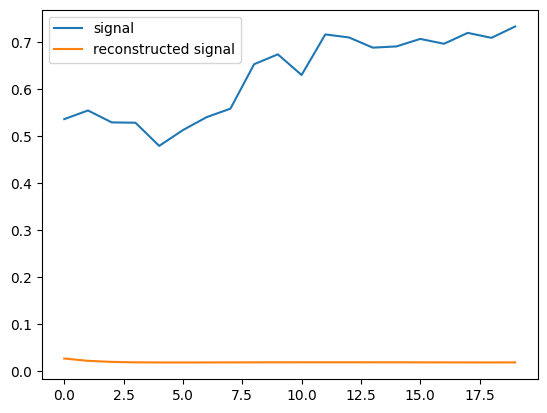

In [89]:
# plot the reconstruction
# get a random signal
random_index = np.random.randint(0, sub_series.shape[0])
output_decoded = output[random_index].squeeze().detach().numpy()
# take the first signal
signal = signal_to_tensor[random_index].squeeze().detach().numpy()
print(signal.shape)
plt.plot(signal, label='signal')
plt.plot(output_decoded, label='reconstructed signal')
plt.legend()
plt.show()


In [90]:
# try a simple overfitting
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#loss_fn = nn.L1Loss(reduction='sum')
loss_fn = nn.MSELoss(reduction='sum')
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(signal_to_tensor)

    loss = loss_fn(output, signal_to_tensor)
    loss.backward()
    # visualize the gradients of the last lstm layer

    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 283.5198974609375
Epoch: 10, loss: 267.593017578125
Epoch: 20, loss: 213.34336853027344
Epoch: 30, loss: 93.36986541748047
Epoch: 40, loss: 69.52848815917969
Epoch: 50, loss: 40.268699645996094
Epoch: 60, loss: 25.534542083740234
Epoch: 70, loss: 17.22353172302246
Epoch: 80, loss: 12.903059005737305
Epoch: 90, loss: 10.903334617614746
Epoch: 100, loss: 9.270517349243164
Epoch: 110, loss: 8.057204246520996
Epoch: 120, loss: 7.036809921264648
Epoch: 130, loss: 6.112303256988525
Epoch: 140, loss: 5.2727227210998535
Epoch: 150, loss: 4.550704002380371
Epoch: 160, loss: 3.9922890663146973
Epoch: 170, loss: 3.6983258724212646
Epoch: 180, loss: 3.4219727516174316
Epoch: 190, loss: 3.228698492050171
Epoch: 200, loss: 3.0785207748413086
Epoch: 210, loss: 2.9289803504943848
Epoch: 220, loss: 2.8052196502685547
Epoch: 230, loss: 2.686089515686035
Epoch: 240, loss: 2.574479103088379
Epoch: 250, loss: 2.4736764430999756
Epoch: 260, loss: 2.4477477073669434
Epoch: 270, loss: 2.316151

KeyboardInterrupt: 

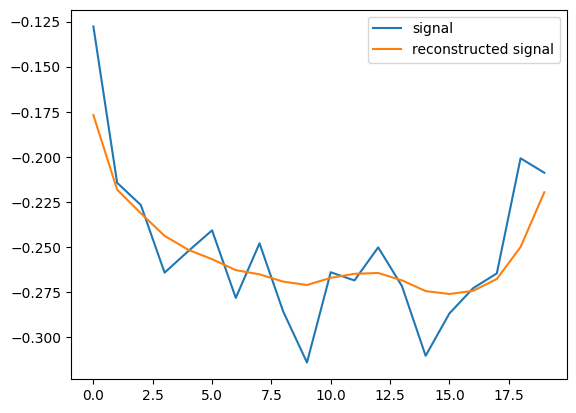

In [91]:
# plot the reconstruction
# get a random signal
random_index = np.random.randint(0, sub_series.shape[0])
output_decoded = output[random_index].squeeze().detach().numpy()
# take the first signal
signal = signal_to_tensor[random_index].squeeze().detach().numpy()
plt.plot(signal, label='signal')
plt.plot(output_decoded, label='reconstructed signal')
plt.legend()
plt.show()


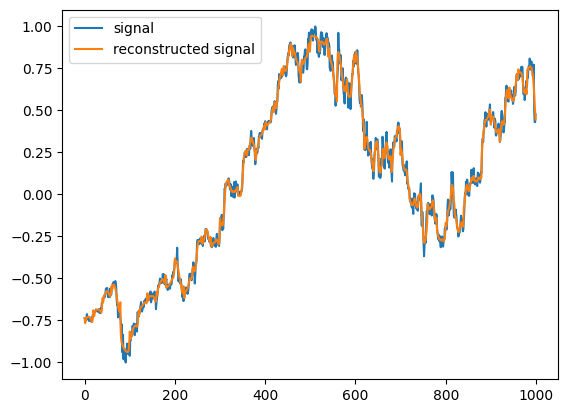

In [92]:
# encode and decode all the signals
singals = model(signal_to_tensor).squeeze().detach().numpy()
# concatenate all the signals

signals = singals.reshape(len(normalized_values))
# plot
plt.plot(normalized_values, label='signal')
plt.plot(signals, label='reconstructed signal')
plt.legend()
plt.show()
